In [1]:
%%writefile utils.py

import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

def g(x, a):
    """
    TBSS kernel applicable to the rBergomi variance process.
    """
    return x**a

def b(k, a):
    """
    Optimal discretisation of TBSS process for minimising hybrid scheme error.
    """
    return ((k**(a+1)-(k-1)**(a+1))/(a+1))**(1/a)

def cov(a, n):
    """
    Covariance matrix for given alpha and n, assuming kappa = 1 for
    tractability.
    """
    cov = np.array([[0.,0.],[0.,0.]])
    cov[0,0] = 1./n
    cov[0,1] = 1./((1.*a+1) * n**(1.*a+1))
    cov[1,1] = 1./((2.*a+1) * n**(2.*a+1))
    cov[1,0] = cov[0,1]
    return cov

def bs(F, K, V, o = 'call'):
    """
    Returns the Black call price for given forward, strike and integrated
    variance.
    """
    # Set appropriate weight for option token o
    w = 1
    if o == 'put':
        w = -1
    elif o == 'otm':
        w = 2 * (K > 1.0) - 1

    sv = np.sqrt(V)
    d1 = np.log(F/K) / sv + 0.5 * sv
    d2 = d1 - sv
    P = w * F * norm.cdf(w * d1) - w * K * norm.cdf(w * d2)
    return P

def bsinv(P, F, K, t, o = 'call'):
    """
    Returns implied Black vol from given call price, forward, strike and time
    to maturity.
    """
    # Set appropriate weight for option token o
    w = 1
    if o == 'put':
        w = -1
    elif o == 'otm':
        w = 2 * (K > 1.0) - 1

    # Ensure at least instrinsic value
    P = np.maximum(P, np.maximum(w * (F - K), 0))

    def error(s):
        return bs(F, K, s**2 * t, o) - P
    s = brentq(error, 1e-9, 1e+9)
    return s

Overwriting utils.py


In [2]:
%%writefile rbergomi.py
import numpy as np
from utils import *

class rBergomi(object):
    """
    Class for generating paths of the rBergomi model.
    """
    def __init__(self, n, N, T, a):
        """
        Constructor for class.
        """
        # Basic assignments
        self.T = T # Maturity
        self.n = n # Granularity (steps per year)
        self.dt = 1.0/self.n # Step size
        self.s = int(self.n * self.T) # Steps
        self.t = np.linspace(0, self.T, 1 + self.s)[np.newaxis,:] # Time grid
        self.a = a # Alpha
        self.N = N # Paths

        # Construct hybrid scheme correlation structure for kappa = 1
        self.e = np.array([0,0])
        self.c = cov(self.a, self.n)

    def dW1(self):
        """
        Produces random numbers for variance process with required
        covariance structure.
        """
        rng = np.random.multivariate_normal
        return rng(self.e, self.c, (self.N, self.s))

    def Y(self, dW):
        """
        Constructs Volterra process from appropriately
        correlated 2d Brownian increments.
        """
        Y1 = np.zeros((self.N, 1 + self.s)) # Exact integrals
        Y2 = np.zeros((self.N, 1 + self.s)) # Riemann sums

        # Construct Y1 through exact integral
        for i in np.arange(1, 1 + self.s, 1):
            Y1[:,i] = dW[:,i-1,1] # Assumes kappa = 1

        # Construct arrays for convolution
        G = np.zeros(1 + self.s) # Gamma
        for k in np.arange(2, 1 + self.s, 1):
            G[k] = g(b(k, self.a)/self.n, self.a)

        X = dW[:,:,0] # Xi

        # Initialise convolution result, GX
        GX = np.zeros((self.N, len(X[0,:]) + len(G) - 1))

        # Compute convolution, FFT not used for small n
        # Possible to compute for all paths in C-layer?
        for i in range(self.N):
            GX[i,:] = np.convolve(G, X[i,:])

        # Extract appropriate part of convolution
        Y2 = GX[:,:1 + self.s]

        # Finally contruct and return full process
        Y = np.sqrt(2 * self.a + 1) * (Y1 + Y2)
        return Y

    def dW2(self):
        """
        Obtain orthogonal increments.
        """
        return np.random.randn(self.N, self.s) * np.sqrt(self.dt)

    def dB(self, dW1, dW2, rho = 0.0):
        """
        Constructs correlated price Brownian increments, dB.
        """
        self.rho = rho
        dB = rho * dW1[:,:,0] + np.sqrt(1 - rho**2) * dW2
        return dB

    def V(self, Y, xi = 1.0, eta = 1.0):
        """
        rBergomi variance process.
        """
        self.xi = xi
        self.eta = eta
        a = self.a
        t = self.t
        V = xi * np.exp(eta * Y - 0.5 * eta**2 * t**(2 * a + 1))
        return V

    def S(self, V, dB, S0 = 1):
        """
        rBergomi price process.
        """
        self.S0 = S0
        dt = self.dt
        rho = self.rho

        # Construct non-anticipative Riemann increments
        increments = np.sqrt(V[:,:-1]) * dB - 0.5 * V[:,:-1] * dt

        # Cumsum is a little slower than Python loop.
        integral = np.cumsum(increments, axis = 1)

        S = np.zeros_like(V)
        S[:,0] = S0
        S[:,1:] = S0 * np.exp(integral)
        return S

    def S1(self, V, dW1, rho, S0 = 1):
        """
        rBergomi parallel price process.
        """
        dt = self.dt

        # Construct non-anticipative Riemann increments
        increments = rho * np.sqrt(V[:,:-1]) * dW1[:,:,0] - 0.5 * rho**2 * V[:,:-1] * dt

        # Cumsum is a little slower than Python loop.
        integral = np.cumsum(increments, axis = 1)

        S = np.zeros_like(V)
        S[:,0] = S0
        S[:,1:] = S0 * np.exp(integral)
        return S

Overwriting rbergomi.py


In [3]:
import numpy as np
import math
from matplotlib import pyplot as plt
from rbergomi import rBergomi
from utils import bsinv
vec_bsinv = np.vectorize(bsinv)
%matplotlib inline
!pip install py_vollib 
import py_vollib
from py_vollib.black_scholes  import black_scholes as bs
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv

In [22]:
# stocks are all martingales.
mu1 = 0;
mu2 = 0;
#initial values for sigma
sigma1_0 = 0.2;
sigma2_0= 0.6;
r = 0;
H1 = 0.1;
eta1 = 1.9**2;
H2 = 0.7;
eta2 = 1.9**2;

rho1=-0;
rho2=-0;
# time increment. To see quasi blow up, set dt = 0.1*1/365
dt = 0.1*1/365;

maturity = np.arange(1,3000,10);#% 1:10:2000;
maturity_len = len(maturity);
maturity_max = maturity[-1]; #Get the last element

#derivative of implied vol at ATM
derivative = np.zeros(maturity_len)-10;

#simulate many paths
num_paths = 30000;

# small number
eps = 0.001;

stock1_paths = np.zeros((num_paths,maturity_max));
sigma1_paths = np.zeros((num_paths, maturity_max));
log_stock1_paths = np.zeros((num_paths, maturity_max));
stock2_paths = np.zeros((num_paths, maturity_max));
sigma2_paths = np.zeros((num_paths, maturity_max));
log_stock2_paths = np.zeros((num_paths, maturity_max));


index = np.zeros((num_paths, maturity_max));

# initial values
S0stock1=100;
S0stock2=95;
stock1_paths[:,0] = S0stock1;
stock2_paths[:,0] = S0stock2;

#initial sigma1,sigma2

sigma1_paths[:,0]=sigma1_0;
sigma2_paths[:,0]=sigma2_0;

#weights for index
w1 = 1;
w2 = 0;
index[:,0] = w1*stock1_paths[0,0]+ w2*stock2_paths[0,0];



MaturityT=dt*maturity_max; # %time to maturity
ndt=math.floor(1/dt); #round 1/dt to an integer
#TimeT=(maturity_max-1)*dt;





In [23]:
#generate the (S1,V1) sample paths
rB1 = rBergomi(n = ndt, N = num_paths, T = MaturityT, a = H1-0.5); #Note here that H-1/2=a ===>H=a+1/2
#np.random.seed(0) #fix random seed
#construct required Brownian increments
dW1_1 = rB1.dW1()
dW2_1 = rB1.dW2()
#Construct the Volterra process
Y1 = rB1.Y(dW1_1)
#Correlate the orthogonal increments, using rho
dB1 = rB1.dB(dW1_1, dW2_1, rho = rho1)
#construct the variance process using zeta and eta
V1 = rB1.V(Y1, xi = sigma1_0, eta = eta1)
#construct the prices process
S1= rB1.S(V1, dB1,S0stock1)
sigma1_paths=V1;
stock1_paths=S1;

#generate the (S21,V21) sample paths
rB2 = rBergomi(n = ndt, N = num_paths, T = MaturityT, a = H2-0.5); #Note here that H-1/2=a ===>H=a+1/2
#np.random.seed(0) #fix random seed
#construct required Brownian increments
dW1_2 = rB2.dW1();
dW2_2 = rB2.dW2();
#Construct the Volterra process
Y2 = rB2.Y(dW1_2);
#Correlate the orthogonal increments, using rho
dB2 = rB2.dB(dW1_2, dW2_2, rho = rho2);
#construct the variance process using zeta and eta
V2 = rB2.V(Y2, xi = sigma2_0, eta = eta2);
#construct the prices process
S2= rB2.S(V2, dB2,S0stock2);
sigma2_paths=V2;
stock2_paths=S2;

#initiate stocks array
stocks=np.zeros((num_paths,2));

for j in range(1,maturity_max-1):  #range must be 1---> to end here
 #Compute index
 #stocks=np.array([stock1_paths[p,j],stock2_paths[p,j]])
 stocks[:,0]=stock1_paths[:,j]
 stocks[:,1]=stock2_paths[:,j]
 #descending sort
 stocks=-stocks;
 stocks.sort();
 stocks=-stocks;
 #index
 index[:,j]=w1*stocks[:,0]+w2*stocks[:,1];
    
    

#derivative of implied vol at ATM
derivative = np.zeros((1,maturity_len));
ATM_implied_vol = np.zeros((1,maturity_len));

# compute index_hat = E[index_{maturity}|F_0],
# which is the price of index future at 0
index_hat = np.zeros((1,maturity_len));

for m in range(0,maturity_len-1):
  index_hat[0,m]=np.mean(index[:,maturity[m]]);
  
for m in range(0,maturity_len-1):
  #compute option price
  #%ATM strike is the price of index future with matrutity maturity(1,m)
  I = index_hat[0,m];
  
  #I = stock1_paths[0,0];
  #% consider two strikes only
  strike =np.zeros((1,2))
  strike[0,0]=I-eps;
  strike[0,1]=I;# [I-eps I];
  log_moneyness =np.log(strike/I);
  strike_len = np.max(strike.shape);
  implied_vol =np.zeros((1,strike_len));
  
 

  #% time to maturity
  TT = maturity[m]*dt;

  for s in range(0,strike_len):
    #% index option price using Monte Carlo
    payoff_index = index[:,maturity[m]] - strike[0,s];
    payoff_index = payoff_index[payoff_index > 0];
    index_call_price = np.sum(payoff_index)/num_paths;
    #%Volatility = blsimpv(Price,Strike,Rate,Time,Value)
    #% compute implied vol, price is now index_hat
    implied_vol[0,s] = iv(index_call_price,I,strike[0,s],maturity[m]*dt,0,'c'); #imp_v = iv(price, S, K, t, r, flag='c','p')
    #call_price_list[0,s] = index_call_price ;
    #% implied vol at ATM
    if strike[0,s] == I:
      ATM_implied_vol[0,m] = iv(index_call_price,I,strike[0,s],TT,0,'c');
    # discret time derivative of implied vol
    derivative[0,m] = (implied_vol[0,0] - implied_vol[0,1])/(log_moneyness[0,0] - log_moneyness[0,1]);
   

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


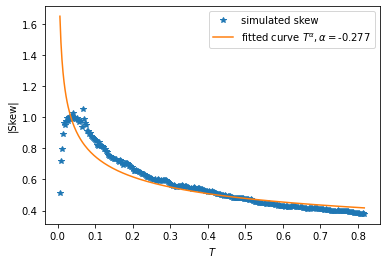

In [24]:
#Fit the Power Regression Model
# this gives quasi blow up
p = np.polyfit(np.log(maturity[2:(maturity_len-1)]*dt),np.log(np.abs(derivative[0,2:(maturity_len-1)])),1);
m_fit = round(p[0],3);
b_fit = np.exp(p[1]);

plt.plot(maturity[2:(maturity_len-1)]*dt,np.abs(derivative[0,2:(maturity_len-1)]),'*',label='simulated skew');
plt.plot(maturity[2:(maturity_len-1)]*dt,b_fit*(maturity[2:(maturity_len-1)]*dt)**(m_fit),label=r"fitted curve $T^\alpha,\alpha=$"+ str(m_fit));
plt.legend()
plt.xlabel(r"$T$")
plt.ylabel("|Skew|")
plt.savefig('rBergomi_2stocks.eps', format='eps')
plt.show()

In [19]:
!pip install hurst

In [104]:
from hurst import compute_Hc, random_walk

In [99]:
!pip install fbm

In [105]:
Hurst = [];

for j in range(0,num_paths-1):
    H, c, data = compute_Hc(np.log(sigma1_paths[j,:]), kind='random_walk', simplified=True);
    Hurst.append(H);

In [106]:
print(np.mean(Hurst))

0.7179580415419621


In [85]:
# we create fBM and test for Hurst parameter

from fbm import FBM

Hurst = [];

for j in range(0,1000):
    # Generate a fBm realization
    f = FBM(2048, 0.2)
    fbm_sample = f.fbm();
    H, c, data = compute_Hc(fbm_sample, kind='random_walk', simplified=True);
    Hurst.append(H);
print(np.mean(Hurst))

0.2976006739073663
